In [1]:
import gym
import numpy as np
import gym_anytrading
from gym_anytrading.envs import StocksEnv
from finta import TA
from numba import jit, cuda

from keras.models import Sequential
from keras.layers import Dense, CuDNNLSTM, Activation, LSTM
from keras.optimizers import Adam

from sb3_contrib import RecurrentPPO
from stable_baselines3.common.vec_env import DummyVecEnv

import pandas as pd

from matplotlib import pyplot as plt

# Importing the Data

In [2]:
df = pd.read_csv("JINDAL.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',ascending=True,inplace=True)
df.set_index('Date',inplace=True)
df['Volume'] = df['Volume'].apply(lambda x: float(x.replace(',','')))

df.head(10)

,Open,High,Low,Close,Volume
Date,,,,,
2021-12-13,318.45,338.90,318.45,336.90,41045.0
2021-12-14,335.00,338.95,330.50,332.90,26577.0
2021-12-15,333.90,340.75,326.55,331.45,25275.0
2021-12-16,333.60,337.00,322.90,327.55,13868.0
2021-12-17,327.50,328.30,313.65,319.80,16554.0
2021-12-20,315.00,315.00,301.10,302.85,32760.0
2021-12-21,301.55,319.40,301.55,317.35,13643.0
2021-12-22,321.55,326.75,317.45,324.85,6333.0
2021-12-23,326.35,329.70,319.00,321.75,10372.0


# Adding Custom Indicators

In [3]:
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df['MACD'] = TA.MACD(df)['MACD']
df['MACD_SIGNAL'] = TA.MACD(df)['SIGNAL']
df.fillna(0,inplace=True)
df.head(15)

,Open,High,Low,Close,Volume,RSI,OBV,MACD,MACD_SIGNAL
Date,,,,,,,,,
2021-12-13,318.45,338.90,318.45,336.90,41045.0,0.000000,0.0,0.000000,0.000000
2021-12-14,335.00,338.95,330.50,332.90,26577.0,0.000000,-26577.0,-0.089744,-0.049858
2021-12-15,333.90,340.75,326.55,331.45,25275.0,0.000000,-51852.0,-0.159316,-0.094717
2021-12-16,333.60,337.00,322.90,327.55,13868.0,0.000000,-65720.0,-0.327862,-0.173696
2021-12-17,327.50,328.30,313.65,319.80,16554.0,0.000000,-82274.0,-0.720935,-0.336487
2021-12-20,315.00,315.00,301.10,302.85,32760.0,0.000000,-115034.0,-1.668467,-0.697528
2021-12-21,301.55,319.40,301.55,317.35,13643.0,33.041870,-101391.0,-1.590514,-0.923519
2021-12-22,321.55,326.75,317.45,324.85,6333.0,43.450050,-95058.0,-1.155973,-0.979382
2021-12-23,326.35,329.70,319.00,321.75,10372.0,40.638207,-105430.0,-0.991275,-0.982129


# Making a sample environment and testing it

In [9]:
env = gym.make('stocks-v0', df=df, frame_bound=(7,150), window_size = 7)

Info: {'total_reward': -0.8999999999999773, 'total_profit': 0.5192820046704716, 'position': 1}


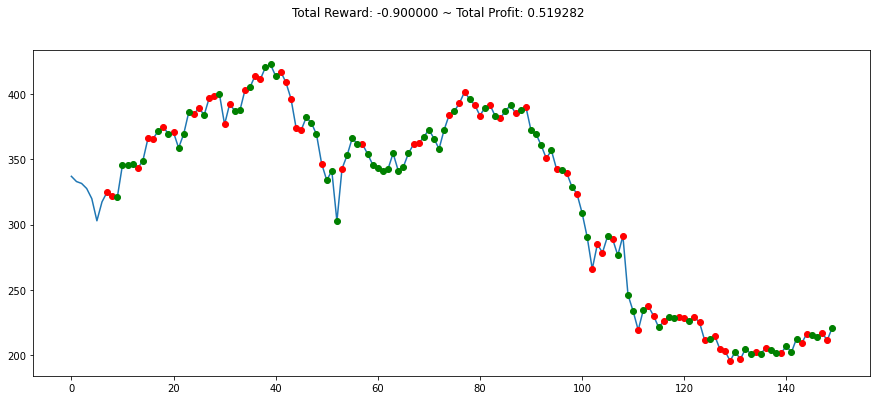

In [10]:
state = env.reset()

while True:
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done:
        print('Info:',info)
        break
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

# Making our custom Environment with the indicators


In [4]:
def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['RSI', 'MACD', 'OBV','Volume', 'Low']].to_numpy()[start:end]
    return prices, signal_features

class MyStocksEnv(StocksEnv):
     _process_data = my_process_data

In [5]:
env = MyStocksEnv(df=df, frame_bound=(7,150), window_size = 7)

# Vectorizing the env and training our model 

In [6]:
env_maker = lambda: env
env = DummyVecEnv([env_maker])

In [16]:
from stable_baselines3.common.callbacks import EvalCallback

# Separate evaluation env
eval_env = MyStocksEnv(df=df, frame_bound=(151,240), window_size = 7)
k = lambda: eval_env
eval_env = DummyVecEnv([k])

#creating the evaluation callback and using evaluation enviroment for evaluating the model
eval_callback = EvalCallback(eval_env, best_model_save_path="./logs/",
                             log_path="logs/", eval_freq=500,
                             deterministic=True, render=False)

#using the lstm policy since each record is depended on previous records
model = RecurrentPPO("MlpLstmPolicy",env, verbose=1,device='cuda:0')
model.learn(total_timesteps=100000,callback=eval_callback)

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1059 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 128  |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 88            |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    total_timesteps      | 256           |
| train/                  |               |
|    approx_kl            | 0.00014738552 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.693        |
|    explained_variance   | 0.0235        |
|    learning_rate        | 0.0003        |
|    loss                 | 191           |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.00257      |
|    value_loss           | 388           |
-------------------------

Eval num_timesteps=1500, episode_reward=-0.10 +/- 0.00
Episode length: 88.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 88           |
|    mean_reward          | -0.1         |
| time/                   |              |
|    total_timesteps      | 1500         |
| train/                  |              |
|    approx_kl            | 0.0004971232 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.689       |
|    explained_variance   | 0.0559       |
|    learning_rate        | 0.0003       |
|    loss                 | 124          |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00284     |
|    value_loss           | 251          |
------------------------------------------
-----------------------------
| time/              |      |
|    fps             | 56   |
|    iterations      | 12   |
|    time_elapsed   

------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 22           |
|    time_elapsed         | 51           |
|    total_timesteps      | 2816         |
| train/                  |              |
|    approx_kl            | 0.0021791668 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.681       |
|    explained_variance   | 0.0564       |
|    learning_rate        | 0.0003       |
|    loss                 | 230          |
|    n_updates            | 210          |
|    policy_gradient_loss | -0.00527     |
|    value_loss           | 468          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 23           |
|    time_elapsed         | 54           |
|    total_

Eval num_timesteps=4000, episode_reward=35.80 +/- 0.00
Episode length: 88.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 88           |
|    mean_reward          | 35.8         |
| time/                   |              |
|    total_timesteps      | 4000         |
| train/                  |              |
|    approx_kl            | 0.0021668363 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.666       |
|    explained_variance   | 0.255        |
|    learning_rate        | 0.0003       |
|    loss                 | 138          |
|    n_updates            | 310          |
|    policy_gradient_loss | -0.00473     |
|    value_loss           | 284          |
------------------------------------------
-----------------------------
| time/              |      |
|    fps             | 53   |
|    iterations      | 32   |
|    time_elapsed   

-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 42          |
|    time_elapsed         | 99          |
|    total_timesteps      | 5376        |
| train/                  |             |
|    approx_kl            | 0.007467773 |
|    clip_fraction        | 0.0211      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.568      |
|    explained_variance   | 0.664       |
|    learning_rate        | 0.0003      |
|    loss                 | 19.9        |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.00931    |
|    value_loss           | 41.9        |
-----------------------------------------
Eval num_timesteps=5500, episode_reward=41.60 +/- 0.00
Episode length: 88.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 88           |
|    mean_reward          | 4

-----------------------------
| time/              |      |
|    fps             | 53   |
|    iterations      | 51   |
|    time_elapsed    | 121  |
|    total_timesteps | 6528 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 53           |
|    iterations           | 52           |
|    time_elapsed         | 123          |
|    total_timesteps      | 6656         |
| train/                  |              |
|    approx_kl            | 0.0016645135 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.586       |
|    explained_variance   | 0.00247      |
|    learning_rate        | 0.0003       |
|    loss                 | 71.8         |
|    n_updates            | 510          |
|    policy_gradient_loss | -0.0047      |
|    value_loss           | 156          |
------------------------------------------
----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 62          |
|    time_elapsed         | 146         |
|    total_timesteps      | 7936        |
| train/                  |             |
|    approx_kl            | 0.001586193 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.586      |
|    explained_variance   | 0.548       |
|    learning_rate        | 0.0003      |
|    loss                 | 62.9        |
|    n_updates            | 610         |
|    policy_gradient_loss | -0.00493    |
|    value_loss           | 135         |
-----------------------------------------
Eval num_timesteps=8000, episode_reward=95.85 +/- 0.00
Episode length: 88.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 88          |
|    mean_reward          | 95.8

-----------------------------
| time/              |      |
|    fps             | 54   |
|    iterations      | 71   |
|    time_elapsed    | 167  |
|    total_timesteps | 9088 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 72          |
|    time_elapsed         | 169         |
|    total_timesteps      | 9216        |
| train/                  |             |
|    approx_kl            | 0.002100765 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.514      |
|    explained_variance   | 0.399       |
|    learning_rate        | 0.0003      |
|    loss                 | 112         |
|    n_updates            | 710         |
|    policy_gradient_loss | -0.00265    |
|    value_loss           | 232         |
-----------------------------------------
----------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 82           |
|    time_elapsed         | 193          |
|    total_timesteps      | 10496        |
| train/                  |              |
|    approx_kl            | 0.0060548894 |
|    clip_fraction        | 0.0133       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.533       |
|    explained_variance   | 0.219        |
|    learning_rate        | 0.0003       |
|    loss                 | 74.5         |
|    n_updates            | 810          |
|    policy_gradient_loss | -0.0127      |
|    value_loss           | 152          |
------------------------------------------
Eval num_timesteps=10500, episode_reward=81.40 +/- 0.00
Episode length: 88.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 88          |
|    mean_rew

------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 92           |
|    time_elapsed         | 216          |
|    total_timesteps      | 11776        |
| train/                  |              |
|    approx_kl            | 0.0030568554 |
|    clip_fraction        | 0.00625      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.46        |
|    explained_variance   | 0.697        |
|    learning_rate        | 0.0003       |
|    loss                 | 91.4         |
|    n_updates            | 910          |
|    policy_gradient_loss | -0.00761     |
|    value_loss           | 186          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 93           |
|    time_elapsed         | 218          |
|    total_

Eval num_timesteps=13000, episode_reward=65.55 +/- 0.00
Episode length: 88.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 88          |
|    mean_reward          | 65.5        |
| time/                   |             |
|    total_timesteps      | 13000       |
| train/                  |             |
|    approx_kl            | 0.010275082 |
|    clip_fraction        | 0.0602      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.47       |
|    explained_variance   | 0.507       |
|    learning_rate        | 0.0003      |
|    loss                 | 238         |
|    n_updates            | 1010        |
|    policy_gradient_loss | -0.0102     |
|    value_loss           | 482         |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 102   |
|    time_elapsed    | 239   |
| 

-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 112         |
|    time_elapsed         | 262         |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.005290851 |
|    clip_fraction        | 0.0148      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.463      |
|    explained_variance   | 0.643       |
|    learning_rate        | 0.0003      |
|    loss                 | 173         |
|    n_updates            | 1110        |
|    policy_gradient_loss | -0.00872    |
|    value_loss           | 353         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 113          |
|    time_elapsed         | 264          |
|    total_timesteps      | 1

Eval num_timesteps=15500, episode_reward=66.10 +/- 0.00
Episode length: 88.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 88           |
|    mean_reward          | 66.1         |
| time/                   |              |
|    total_timesteps      | 15500        |
| train/                  |              |
|    approx_kl            | 0.0007924957 |
|    clip_fraction        | 0.00234      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.4         |
|    explained_variance   | 0.367        |
|    learning_rate        | 0.0003       |
|    loss                 | 272          |
|    n_updates            | 1210         |
|    policy_gradient_loss | -0.00374     |
|    value_loss           | 574          |
------------------------------------------
------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 122   |
|    time_elaps

-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 132         |
|    time_elapsed         | 309         |
|    total_timesteps      | 16896       |
| train/                  |             |
|    approx_kl            | 0.008531721 |
|    clip_fraction        | 0.0477      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.401      |
|    explained_variance   | 0.59        |
|    learning_rate        | 0.0003      |
|    loss                 | 181         |
|    n_updates            | 1310        |
|    policy_gradient_loss | -0.00569    |
|    value_loss           | 366         |
-----------------------------------------
Eval num_timesteps=17000, episode_reward=69.00 +/- 0.00
Episode length: 88.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 88          |
|    mean_reward          | 69 

------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 141   |
|    time_elapsed    | 330   |
|    total_timesteps | 18048 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 142         |
|    time_elapsed         | 333         |
|    total_timesteps      | 18176       |
| train/                  |             |
|    approx_kl            | 0.005573566 |
|    clip_fraction        | 0.0242      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.393      |
|    explained_variance   | 0.615       |
|    learning_rate        | 0.0003      |
|    loss                 | 222         |
|    n_updates            | 1410        |
|    policy_gradient_loss | -0.01       |
|    value_loss           | 452         |
-----------------------------------------
---------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 152          |
|    time_elapsed         | 356          |
|    total_timesteps      | 19456        |
| train/                  |              |
|    approx_kl            | 0.0007898251 |
|    clip_fraction        | 0.000781     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.403       |
|    explained_variance   | 0.567        |
|    learning_rate        | 0.0003       |
|    loss                 | 165          |
|    n_updates            | 1510         |
|    policy_gradient_loss | -0.00475     |
|    value_loss           | 332          |
------------------------------------------
Eval num_timesteps=19500, episode_reward=34.60 +/- 0.00
Episode length: 88.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 88           |
|    mean_

------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 161   |
|    time_elapsed    | 377   |
|    total_timesteps | 20608 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 162          |
|    time_elapsed         | 379          |
|    total_timesteps      | 20736        |
| train/                  |              |
|    approx_kl            | 0.0041746614 |
|    clip_fraction        | 0.0195       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.342       |
|    explained_variance   | 0.561        |
|    learning_rate        | 0.0003       |
|    loss                 | 190          |
|    n_updates            | 1610         |
|    policy_gradient_loss | -0.00734     |
|    value_loss           | 390          |
------------------------------------------
---------

Eval num_timesteps=22000, episode_reward=72.75 +/- 0.00
Episode length: 88.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 88           |
|    mean_reward          | 72.7         |
| time/                   |              |
|    total_timesteps      | 22000        |
| train/                  |              |
|    approx_kl            | 0.0061064856 |
|    clip_fraction        | 0.0242       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.352       |
|    explained_variance   | 0.61         |
|    learning_rate        | 0.0003       |
|    loss                 | 248          |
|    n_updates            | 1710         |
|    policy_gradient_loss | -0.00989     |
|    value_loss           | 500          |
------------------------------------------
------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 172   |
|    time_elaps

-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 182         |
|    time_elapsed         | 425         |
|    total_timesteps      | 23296       |
| train/                  |             |
|    approx_kl            | 0.007110574 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.31       |
|    explained_variance   | 0.544       |
|    learning_rate        | 0.0003      |
|    loss                 | 269         |
|    n_updates            | 1810        |
|    policy_gradient_loss | -0.00696    |
|    value_loss           | 545         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 183         |
|    time_elapsed         | 427         |
|    total_timesteps      | 23424 

Eval num_timesteps=24500, episode_reward=68.90 +/- 0.00
Episode length: 88.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 88           |
|    mean_reward          | 68.9         |
| time/                   |              |
|    total_timesteps      | 24500        |
| train/                  |              |
|    approx_kl            | 0.0034456917 |
|    clip_fraction        | 0.0102       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.313       |
|    explained_variance   | 0.563        |
|    learning_rate        | 0.0003       |
|    loss                 | 281          |
|    n_updates            | 1910         |
|    policy_gradient_loss | -0.00935     |
|    value_loss           | 572          |
------------------------------------------
------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 192   |
|    time_elaps

------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 202          |
|    time_elapsed         | 472          |
|    total_timesteps      | 25856        |
| train/                  |              |
|    approx_kl            | 0.0049588303 |
|    clip_fraction        | 0.0406       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.313       |
|    explained_variance   | 0.622        |
|    learning_rate        | 0.0003       |
|    loss                 | 314          |
|    n_updates            | 2010         |
|    policy_gradient_loss | -0.00799     |
|    value_loss           | 631          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 203          |
|    time_elapsed         | 475          |
|    total_

------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 211   |
|    time_elapsed    | 493   |
|    total_timesteps | 27008 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 212         |
|    time_elapsed         | 495         |
|    total_timesteps      | 27136       |
| train/                  |             |
|    approx_kl            | 0.004633862 |
|    clip_fraction        | 0.0141      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.291      |
|    explained_variance   | 0.701       |
|    learning_rate        | 0.0003      |
|    loss                 | 263         |
|    n_updates            | 2110        |
|    policy_gradient_loss | -0.00385    |
|    value_loss           | 528         |
-----------------------------------------
---------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 222          |
|    time_elapsed         | 518          |
|    total_timesteps      | 28416        |
| train/                  |              |
|    approx_kl            | 0.0031414793 |
|    clip_fraction        | 0.00703      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.279       |
|    explained_variance   | 0.659        |
|    learning_rate        | 0.0003       |
|    loss                 | 383          |
|    n_updates            | 2210         |
|    policy_gradient_loss | -0.0022      |
|    value_loss           | 772          |
------------------------------------------
Eval num_timesteps=28500, episode_reward=79.95 +/- 0.00
Episode length: 88.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 88           |
|    mean_

------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 231   |
|    time_elapsed    | 539   |
|    total_timesteps | 29568 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 232          |
|    time_elapsed         | 542          |
|    total_timesteps      | 29696        |
| train/                  |              |
|    approx_kl            | 0.0029644847 |
|    clip_fraction        | 0.0148       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.201       |
|    explained_variance   | 0.616        |
|    learning_rate        | 0.0003       |
|    loss                 | 318          |
|    n_updates            | 2310         |
|    policy_gradient_loss | -0.00595     |
|    value_loss           | 658          |
------------------------------------------
---------

-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 242         |
|    time_elapsed         | 565         |
|    total_timesteps      | 30976       |
| train/                  |             |
|    approx_kl            | 0.010207989 |
|    clip_fraction        | 0.0727      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.241      |
|    explained_variance   | 0.727       |
|    learning_rate        | 0.0003      |
|    loss                 | 253         |
|    n_updates            | 2410        |
|    policy_gradient_loss | -0.00324    |
|    value_loss           | 513         |
-----------------------------------------
Eval num_timesteps=31000, episode_reward=87.80 +/- 0.00
Episode length: 88.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 88          |
|    mean_reward          | 87.

-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 252         |
|    time_elapsed         | 589         |
|    total_timesteps      | 32256       |
| train/                  |             |
|    approx_kl            | 0.011973883 |
|    clip_fraction        | 0.0461      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.229      |
|    explained_variance   | 0.686       |
|    learning_rate        | 0.0003      |
|    loss                 | 240         |
|    n_updates            | 2510        |
|    policy_gradient_loss | -0.00835    |
|    value_loss           | 487         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 253         |
|    time_elapsed         | 591         |
|    total_timesteps      | 32384 

Eval num_timesteps=33500, episode_reward=83.05 +/- 0.00
Episode length: 88.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 88         |
|    mean_reward          | 83         |
| time/                   |            |
|    total_timesteps      | 33500      |
| train/                  |            |
|    approx_kl            | 0.00421135 |
|    clip_fraction        | 0.0148     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.207     |
|    explained_variance   | 0.724      |
|    learning_rate        | 0.0003     |
|    loss                 | 275        |
|    n_updates            | 2610       |
|    policy_gradient_loss | -0.00337   |
|    value_loss           | 553        |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 262   |
|    time_elapsed    | 612   |
|    total_timesteps

------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 272          |
|    time_elapsed         | 635          |
|    total_timesteps      | 34816        |
| train/                  |              |
|    approx_kl            | 0.0035272252 |
|    clip_fraction        | 0.00781      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.252       |
|    explained_variance   | 0.707        |
|    learning_rate        | 0.0003       |
|    loss                 | 304          |
|    n_updates            | 2710         |
|    policy_gradient_loss | -0.00249     |
|    value_loss           | 610          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 273          |
|    time_elapsed         | 637          |
|    total_

Eval num_timesteps=36000, episode_reward=95.90 +/- 0.00
Episode length: 88.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 88           |
|    mean_reward          | 95.9         |
| time/                   |              |
|    total_timesteps      | 36000        |
| train/                  |              |
|    approx_kl            | 0.0030179983 |
|    clip_fraction        | 0.0133       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.245       |
|    explained_variance   | 0.739        |
|    learning_rate        | 0.0003       |
|    loss                 | 313          |
|    n_updates            | 2810         |
|    policy_gradient_loss | -0.00519     |
|    value_loss           | 632          |
------------------------------------------
------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 282   |
|    time_elaps

------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 292          |
|    time_elapsed         | 681          |
|    total_timesteps      | 37376        |
| train/                  |              |
|    approx_kl            | 0.0010542567 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.218       |
|    explained_variance   | 0.591        |
|    learning_rate        | 0.0003       |
|    loss                 | 387          |
|    n_updates            | 2910         |
|    policy_gradient_loss | -0.000349    |
|    value_loss           | 811          |
------------------------------------------
Eval num_timesteps=37500, episode_reward=92.05 +/- 0.00
Episode length: 88.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 88           |
|    mean_

------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 301   |
|    time_elapsed    | 702   |
|    total_timesteps | 38528 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 302          |
|    time_elapsed         | 704          |
|    total_timesteps      | 38656        |
| train/                  |              |
|    approx_kl            | 0.0014270295 |
|    clip_fraction        | 0.0242       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.23        |
|    explained_variance   | 0.774        |
|    learning_rate        | 0.0003       |
|    loss                 | 290          |
|    n_updates            | 3010         |
|    policy_gradient_loss | -0.000895    |
|    value_loss           | 585          |
------------------------------------------
---------

-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 312         |
|    time_elapsed         | 727         |
|    total_timesteps      | 39936       |
| train/                  |             |
|    approx_kl            | 0.002709524 |
|    clip_fraction        | 0.0109      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.209      |
|    explained_variance   | 0.764       |
|    learning_rate        | 0.0003      |
|    loss                 | 260         |
|    n_updates            | 3110        |
|    policy_gradient_loss | -0.00171    |
|    value_loss           | 523         |
-----------------------------------------
Eval num_timesteps=40000, episode_reward=95.90 +/- 0.00
Episode length: 88.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 88          |
|    mean_reward          | 95.

------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 321   |
|    time_elapsed    | 748   |
|    total_timesteps | 41088 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 322         |
|    time_elapsed         | 750         |
|    total_timesteps      | 41216       |
| train/                  |             |
|    approx_kl            | 0.004441177 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.243      |
|    explained_variance   | 0.739       |
|    learning_rate        | 0.0003      |
|    loss                 | 431         |
|    n_updates            | 3210        |
|    policy_gradient_loss | -0.0031     |
|    value_loss           | 870         |
-----------------------------------------
---------------------------

-------------------------------------------
| time/                   |               |
|    fps                  | 54            |
|    iterations           | 332           |
|    time_elapsed         | 773           |
|    total_timesteps      | 42496         |
| train/                  |               |
|    approx_kl            | 0.00077965437 |
|    clip_fraction        | 0.000781      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.214        |
|    explained_variance   | 0.787         |
|    learning_rate        | 0.0003        |
|    loss                 | 405           |
|    n_updates            | 3310          |
|    policy_gradient_loss | -0.00183      |
|    value_loss           | 815           |
-------------------------------------------
Eval num_timesteps=42500, episode_reward=95.90 +/- 0.00
Episode length: 88.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 88       

-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 342         |
|    time_elapsed         | 797         |
|    total_timesteps      | 43776       |
| train/                  |             |
|    approx_kl            | 0.009297408 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 0.818       |
|    learning_rate        | 0.0003      |
|    loss                 | 406         |
|    n_updates            | 3410        |
|    policy_gradient_loss | -0.00339    |
|    value_loss           | 829         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 343         |
|    time_elapsed         | 800         |
|    total_timesteps      | 43904 

Eval num_timesteps=45000, episode_reward=95.90 +/- 0.00
Episode length: 88.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 88           |
|    mean_reward          | 95.9         |
| time/                   |              |
|    total_timesteps      | 45000        |
| train/                  |              |
|    approx_kl            | 0.0070802732 |
|    clip_fraction        | 0.0219       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.211       |
|    explained_variance   | 0.767        |
|    learning_rate        | 0.0003       |
|    loss                 | 396          |
|    n_updates            | 3510         |
|    policy_gradient_loss | -0.00599     |
|    value_loss           | 796          |
------------------------------------------
------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 352   |
|    time_elaps

------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 362          |
|    time_elapsed         | 843          |
|    total_timesteps      | 46336        |
| train/                  |              |
|    approx_kl            | 0.0018683118 |
|    clip_fraction        | 0.00625      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.229       |
|    explained_variance   | 0.777        |
|    learning_rate        | 0.0003       |
|    loss                 | 390          |
|    n_updates            | 3610         |
|    policy_gradient_loss | -0.0028      |
|    value_loss           | 785          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 363          |
|    time_elapsed         | 845          |
|    total_

Eval num_timesteps=47500, episode_reward=78.90 +/- 0.00
Episode length: 88.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 88          |
|    mean_reward          | 78.9        |
| time/                   |             |
|    total_timesteps      | 47500       |
| train/                  |             |
|    approx_kl            | 0.003236822 |
|    clip_fraction        | 0.0164      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.206      |
|    explained_variance   | 0.796       |
|    learning_rate        | 0.0003      |
|    loss                 | 414         |
|    n_updates            | 3710        |
|    policy_gradient_loss | -0.00505    |
|    value_loss           | 832         |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 372   |
|    time_elapsed    | 867   |
| 

------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 382          |
|    time_elapsed         | 890          |
|    total_timesteps      | 48896        |
| train/                  |              |
|    approx_kl            | 0.0016512768 |
|    clip_fraction        | 0.00469      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.167       |
|    explained_variance   | 0.806        |
|    learning_rate        | 0.0003       |
|    loss                 | 418          |
|    n_updates            | 3810         |
|    policy_gradient_loss | -0.00265     |
|    value_loss           | 840          |
------------------------------------------
Eval num_timesteps=49000, episode_reward=57.60 +/- 0.00
Episode length: 88.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 88           |
|    mean_

------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 391   |
|    time_elapsed    | 912   |
|    total_timesteps | 50048 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 392          |
|    time_elapsed         | 914          |
|    total_timesteps      | 50176        |
| train/                  |              |
|    approx_kl            | 0.0013827623 |
|    clip_fraction        | 0.00781      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.173       |
|    explained_variance   | 0.772        |
|    learning_rate        | 0.0003       |
|    loss                 | 407          |
|    n_updates            | 3910         |
|    policy_gradient_loss | -0.00453     |
|    value_loss           | 835          |
------------------------------------------
---------

------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 402          |
|    time_elapsed         | 937          |
|    total_timesteps      | 51456        |
| train/                  |              |
|    approx_kl            | 0.0018185824 |
|    clip_fraction        | 0.00625      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.214       |
|    explained_variance   | 0.831        |
|    learning_rate        | 0.0003       |
|    loss                 | 324          |
|    n_updates            | 4010         |
|    policy_gradient_loss | -0.00165     |
|    value_loss           | 654          |
------------------------------------------
Eval num_timesteps=51500, episode_reward=81.85 +/- 0.00
Episode length: 88.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 88          |
|    mean_rew

------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 411   |
|    time_elapsed    | 959   |
|    total_timesteps | 52608 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 412          |
|    time_elapsed         | 961          |
|    total_timesteps      | 52736        |
| train/                  |              |
|    approx_kl            | 0.0127920685 |
|    clip_fraction        | 0.0641       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.248       |
|    explained_variance   | 0.848        |
|    learning_rate        | 0.0003       |
|    loss                 | 288          |
|    n_updates            | 4110         |
|    policy_gradient_loss | -0.00673     |
|    value_loss           | 585          |
------------------------------------------
---------

Eval num_timesteps=54000, episode_reward=20.10 +/- 0.00
Episode length: 88.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 88          |
|    mean_reward          | 20.1        |
| time/                   |             |
|    total_timesteps      | 54000       |
| train/                  |             |
|    approx_kl            | 0.005687972 |
|    clip_fraction        | 0.0273      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.161      |
|    explained_variance   | 0.812       |
|    learning_rate        | 0.0003      |
|    loss                 | 358         |
|    n_updates            | 4210        |
|    policy_gradient_loss | -0.00578    |
|    value_loss           | 722         |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 422   |
|    time_elapsed    | 984   |
| 

------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 432          |
|    time_elapsed         | 1008         |
|    total_timesteps      | 55296        |
| train/                  |              |
|    approx_kl            | 0.0030793976 |
|    clip_fraction        | 0.0117       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.136       |
|    explained_variance   | 0.837        |
|    learning_rate        | 0.0003       |
|    loss                 | 373          |
|    n_updates            | 4310         |
|    policy_gradient_loss | -0.00271     |
|    value_loss           | 750          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 433          |
|    time_elapsed         | 1010         |
|    total_

Eval num_timesteps=56500, episode_reward=92.80 +/- 0.00
Episode length: 88.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 88          |
|    mean_reward          | 92.8        |
| time/                   |             |
|    total_timesteps      | 56500       |
| train/                  |             |
|    approx_kl            | 0.009926777 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 0.824       |
|    learning_rate        | 0.0003      |
|    loss                 | 335         |
|    n_updates            | 4410        |
|    policy_gradient_loss | -0.00791    |
|    value_loss           | 675         |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 442   |
|    time_elapsed    | 1031  |
| 

-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 452         |
|    time_elapsed         | 1054        |
|    total_timesteps      | 57856       |
| train/                  |             |
|    approx_kl            | 0.004826516 |
|    clip_fraction        | 0.0211      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.183      |
|    explained_variance   | 0.857       |
|    learning_rate        | 0.0003      |
|    loss                 | 338         |
|    n_updates            | 4510        |
|    policy_gradient_loss | -0.00299    |
|    value_loss           | 679         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 453         |
|    time_elapsed         | 1056        |
|    total_timesteps      | 57984 

------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 461   |
|    time_elapsed    | 1076  |
|    total_timesteps | 59008 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 462          |
|    time_elapsed         | 1078         |
|    total_timesteps      | 59136        |
| train/                  |              |
|    approx_kl            | 0.0018523224 |
|    clip_fraction        | 0.00625      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.248       |
|    explained_variance   | 0.819        |
|    learning_rate        | 0.0003       |
|    loss                 | 347          |
|    n_updates            | 4610         |
|    policy_gradient_loss | -0.00217     |
|    value_loss           | 701          |
------------------------------------------
---------

-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 472         |
|    time_elapsed         | 1102        |
|    total_timesteps      | 60416       |
| train/                  |             |
|    approx_kl            | 0.004237984 |
|    clip_fraction        | 0.00625     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.267      |
|    explained_variance   | 0.864       |
|    learning_rate        | 0.0003      |
|    loss                 | 316         |
|    n_updates            | 4710        |
|    policy_gradient_loss | -0.00239    |
|    value_loss           | 635         |
-----------------------------------------
Eval num_timesteps=60500, episode_reward=89.95 +/- 0.00
Episode length: 88.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 88          |
|    mean_reward          | 89.

------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 481   |
|    time_elapsed    | 1123  |
|    total_timesteps | 61568 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 482         |
|    time_elapsed         | 1125        |
|    total_timesteps      | 61696       |
| train/                  |             |
|    approx_kl            | 0.004046991 |
|    clip_fraction        | 0.00781     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.261      |
|    explained_variance   | 0.856       |
|    learning_rate        | 0.0003      |
|    loss                 | 325         |
|    n_updates            | 4810        |
|    policy_gradient_loss | -0.00212    |
|    value_loss           | 655         |
-----------------------------------------
---------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 492         |
|    time_elapsed         | 1149        |
|    total_timesteps      | 62976       |
| train/                  |             |
|    approx_kl            | 0.012904357 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.264      |
|    explained_variance   | 0.864       |
|    learning_rate        | 0.0003      |
|    loss                 | 281         |
|    n_updates            | 4910        |
|    policy_gradient_loss | -0.00599    |
|    value_loss           | 567         |
-----------------------------------------
Eval num_timesteps=63000, episode_reward=95.90 +/- 0.00
Episode length: 88.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 88          |
|    mean_reward          | 95.

----------------------------------------
| time/                   |            |
|    fps                  | 54         |
|    iterations           | 502        |
|    time_elapsed         | 1173       |
|    total_timesteps      | 64256      |
| train/                  |            |
|    approx_kl            | 0.03470237 |
|    clip_fraction        | 0.155      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.245     |
|    explained_variance   | 0.861      |
|    learning_rate        | 0.0003     |
|    loss                 | 332        |
|    n_updates            | 5010       |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 670        |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 503          |
|    time_elapsed         | 1175         |
|    total_timesteps      | 64384        |
| tr

Eval num_timesteps=65500, episode_reward=86.20 +/- 0.00
Episode length: 88.00 +/- 0.00
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 88       |
|    mean_reward          | 86.2     |
| time/                   |          |
|    total_timesteps      | 65500    |
| train/                  |          |
|    approx_kl            | 0.009722 |
|    clip_fraction        | 0.0844   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.228   |
|    explained_variance   | 0.879    |
|    learning_rate        | 0.0003   |
|    loss                 | 317      |
|    n_updates            | 5110     |
|    policy_gradient_loss | -0.0063  |
|    value_loss           | 637      |
--------------------------------------
------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 512   |
|    time_elapsed    | 1197  |
|    total_timesteps | 65536 |
-------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 522          |
|    time_elapsed         | 1220         |
|    total_timesteps      | 66816        |
| train/                  |              |
|    approx_kl            | 0.0018480632 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.222       |
|    explained_variance   | 0.872        |
|    learning_rate        | 0.0003       |
|    loss                 | 293          |
|    n_updates            | 5210         |
|    policy_gradient_loss | -0.00193     |
|    value_loss           | 594          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 523         |
|    time_elapsed         | 1222        |
|    total_times

Eval num_timesteps=68000, episode_reward=38.70 +/- 0.00
Episode length: 88.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 88           |
|    mean_reward          | 38.7         |
| time/                   |              |
|    total_timesteps      | 68000        |
| train/                  |              |
|    approx_kl            | 0.0032038754 |
|    clip_fraction        | 0.0109       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.205       |
|    explained_variance   | 0.863        |
|    learning_rate        | 0.0003       |
|    loss                 | 350          |
|    n_updates            | 5310         |
|    policy_gradient_loss | -0.00315     |
|    value_loss           | 703          |
------------------------------------------
------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 532   |
|    time_elaps

------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 542          |
|    time_elapsed         | 1267         |
|    total_timesteps      | 69376        |
| train/                  |              |
|    approx_kl            | 0.0031825872 |
|    clip_fraction        | 0.0242       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.148       |
|    explained_variance   | 0.891        |
|    learning_rate        | 0.0003       |
|    loss                 | 241          |
|    n_updates            | 5410         |
|    policy_gradient_loss | -0.00415     |
|    value_loss           | 486          |
------------------------------------------
Eval num_timesteps=69500, episode_reward=17.65 +/- 0.00
Episode length: 88.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 88          |
|    mean_rew

------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 551   |
|    time_elapsed    | 1289  |
|    total_timesteps | 70528 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 552          |
|    time_elapsed         | 1292         |
|    total_timesteps      | 70656        |
| train/                  |              |
|    approx_kl            | 0.0028622514 |
|    clip_fraction        | 0.0297       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.157       |
|    explained_variance   | 0.871        |
|    learning_rate        | 0.0003       |
|    loss                 | 252          |
|    n_updates            | 5510         |
|    policy_gradient_loss | -0.00491     |
|    value_loss           | 515          |
------------------------------------------
---------

------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 562          |
|    time_elapsed         | 1314         |
|    total_timesteps      | 71936        |
| train/                  |              |
|    approx_kl            | 0.0018538502 |
|    clip_fraction        | 0.00547      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.165       |
|    explained_variance   | 0.892        |
|    learning_rate        | 0.0003       |
|    loss                 | 259          |
|    n_updates            | 5610         |
|    policy_gradient_loss | -0.00175     |
|    value_loss           | 521          |
------------------------------------------
Eval num_timesteps=72000, episode_reward=64.45 +/- 0.00
Episode length: 88.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 88           |
|    mean_

------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 571   |
|    time_elapsed    | 1335  |
|    total_timesteps | 73088 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 572         |
|    time_elapsed         | 1337        |
|    total_timesteps      | 73216       |
| train/                  |             |
|    approx_kl            | 0.008675552 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.221      |
|    explained_variance   | 0.899       |
|    learning_rate        | 0.0003      |
|    loss                 | 289         |
|    n_updates            | 5710        |
|    policy_gradient_loss | -0.00613    |
|    value_loss           | 585         |
-----------------------------------------
---------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 582          |
|    time_elapsed         | 1360         |
|    total_timesteps      | 74496        |
| train/                  |              |
|    approx_kl            | 0.0023628029 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.175       |
|    explained_variance   | 0.905        |
|    learning_rate        | 0.0003       |
|    loss                 | 265          |
|    n_updates            | 5810         |
|    policy_gradient_loss | -0.00232     |
|    value_loss           | 535          |
------------------------------------------
Eval num_timesteps=74500, episode_reward=87.80 +/- 0.00
Episode length: 88.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 88          |
|    mean_rew

-------------------------------------------
| time/                   |               |
|    fps                  | 54            |
|    iterations           | 592           |
|    time_elapsed         | 1383          |
|    total_timesteps      | 75776         |
| train/                  |               |
|    approx_kl            | 0.00020770845 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.188        |
|    explained_variance   | 0.897         |
|    learning_rate        | 0.0003        |
|    loss                 | 233           |
|    n_updates            | 5910          |
|    policy_gradient_loss | 0.000651      |
|    value_loss           | 470           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 593          |
|    time_elapsed         | 1386    

Eval num_timesteps=77000, episode_reward=91.65 +/- 0.00
Episode length: 88.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 88          |
|    mean_reward          | 91.6        |
| time/                   |             |
|    total_timesteps      | 77000       |
| train/                  |             |
|    approx_kl            | 0.019383613 |
|    clip_fraction        | 0.0656      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.205      |
|    explained_variance   | 0.901       |
|    learning_rate        | 0.0003      |
|    loss                 | 206         |
|    n_updates            | 6010        |
|    policy_gradient_loss | -0.00588    |
|    value_loss           | 421         |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 602   |
|    time_elapsed    | 1407  |
| 

-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 612         |
|    time_elapsed         | 1430        |
|    total_timesteps      | 78336       |
| train/                  |             |
|    approx_kl            | 0.003800769 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.185      |
|    explained_variance   | 0.91        |
|    learning_rate        | 0.0003      |
|    loss                 | 198         |
|    n_updates            | 6110        |
|    policy_gradient_loss | -0.0027     |
|    value_loss           | 401         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 613          |
|    time_elapsed         | 1432         |
|    total_timesteps      | 7

Eval num_timesteps=79500, episode_reward=96.20 +/- 0.00
Episode length: 88.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 88          |
|    mean_reward          | 96.2        |
| time/                   |             |
|    total_timesteps      | 79500       |
| train/                  |             |
|    approx_kl            | 0.011223411 |
|    clip_fraction        | 0.0586      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.18       |
|    explained_variance   | 0.914       |
|    learning_rate        | 0.0003      |
|    loss                 | 218         |
|    n_updates            | 6210        |
|    policy_gradient_loss | -0.00446    |
|    value_loss           | 439         |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 622   |
|    time_elapsed    | 1453  |
| 

------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 632          |
|    time_elapsed         | 1476         |
|    total_timesteps      | 80896        |
| train/                  |              |
|    approx_kl            | 0.0020027459 |
|    clip_fraction        | 0.0109       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.171       |
|    explained_variance   | 0.907        |
|    learning_rate        | 0.0003       |
|    loss                 | 233          |
|    n_updates            | 6310         |
|    policy_gradient_loss | -0.00364     |
|    value_loss           | 477          |
------------------------------------------
Eval num_timesteps=81000, episode_reward=92.05 +/- 0.00
Episode length: 88.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 88           |
|    mean_

------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 641   |
|    time_elapsed    | 1497  |
|    total_timesteps | 82048 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 642         |
|    time_elapsed         | 1499        |
|    total_timesteps      | 82176       |
| train/                  |             |
|    approx_kl            | 0.006275021 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.18       |
|    explained_variance   | 0.912       |
|    learning_rate        | 0.0003      |
|    loss                 | 249         |
|    n_updates            | 6410        |
|    policy_gradient_loss | -0.00545    |
|    value_loss           | 499         |
-----------------------------------------
---------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 652         |
|    time_elapsed         | 1524        |
|    total_timesteps      | 83456       |
| train/                  |             |
|    approx_kl            | 0.003036042 |
|    clip_fraction        | 0.0133      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.15       |
|    explained_variance   | 0.92        |
|    learning_rate        | 0.0003      |
|    loss                 | 184         |
|    n_updates            | 6510        |
|    policy_gradient_loss | -0.00419    |
|    value_loss           | 371         |
-----------------------------------------
Eval num_timesteps=83500, episode_reward=57.20 +/- 0.00
Episode length: 88.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 88          |
|    mean_reward          | 57.

------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 661   |
|    time_elapsed    | 1545  |
|    total_timesteps | 84608 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 662         |
|    time_elapsed         | 1547        |
|    total_timesteps      | 84736       |
| train/                  |             |
|    approx_kl            | 0.004346306 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.164      |
|    explained_variance   | 0.904       |
|    learning_rate        | 0.0003      |
|    loss                 | 234         |
|    n_updates            | 6610        |
|    policy_gradient_loss | -0.00312    |
|    value_loss           | 472         |
-----------------------------------------
---------------------------

Eval num_timesteps=86000, episode_reward=86.30 +/- 0.00
Episode length: 88.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 88          |
|    mean_reward          | 86.3        |
| time/                   |             |
|    total_timesteps      | 86000       |
| train/                  |             |
|    approx_kl            | 0.004071299 |
|    clip_fraction        | 0.0414      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.192      |
|    explained_variance   | 0.92        |
|    learning_rate        | 0.0003      |
|    loss                 | 214         |
|    n_updates            | 6710        |
|    policy_gradient_loss | -0.00367    |
|    value_loss           | 432         |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 672   |
|    time_elapsed    | 1571  |
| 

------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 682          |
|    time_elapsed         | 1594         |
|    total_timesteps      | 87296        |
| train/                  |              |
|    approx_kl            | 0.0035730556 |
|    clip_fraction        | 0.0102       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.194       |
|    explained_variance   | 0.914        |
|    learning_rate        | 0.0003       |
|    loss                 | 190          |
|    n_updates            | 6810         |
|    policy_gradient_loss | -0.00222     |
|    value_loss           | 391          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 683          |
|    time_elapsed         | 1597         |
|    total_

Eval num_timesteps=88500, episode_reward=93.05 +/- 0.00
Episode length: 88.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 88         |
|    mean_reward          | 93         |
| time/                   |            |
|    total_timesteps      | 88500      |
| train/                  |            |
|    approx_kl            | 0.02512854 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.198     |
|    explained_variance   | 0.918      |
|    learning_rate        | 0.0003     |
|    loss                 | 196        |
|    n_updates            | 6910       |
|    policy_gradient_loss | -0.00804   |
|    value_loss           | 396        |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 692   |
|    time_elapsed    | 1617  |
|    total_timesteps

-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 702         |
|    time_elapsed         | 1641        |
|    total_timesteps      | 89856       |
| train/                  |             |
|    approx_kl            | 0.004422283 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.172      |
|    explained_variance   | 0.933       |
|    learning_rate        | 0.0003      |
|    loss                 | 180         |
|    n_updates            | 7010        |
|    policy_gradient_loss | -0.00118    |
|    value_loss           | 367         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 703          |
|    time_elapsed         | 1643         |
|    total_timesteps      | 8

------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 711   |
|    time_elapsed    | 1662  |
|    total_timesteps | 91008 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 712         |
|    time_elapsed         | 1665        |
|    total_timesteps      | 91136       |
| train/                  |             |
|    approx_kl            | 0.011066994 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.184      |
|    explained_variance   | 0.924       |
|    learning_rate        | 0.0003      |
|    loss                 | 179         |
|    n_updates            | 7110        |
|    policy_gradient_loss | -0.00466    |
|    value_loss           | 365         |
-----------------------------------------
---------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 722          |
|    time_elapsed         | 1688         |
|    total_timesteps      | 92416        |
| train/                  |              |
|    approx_kl            | 0.0108658075 |
|    clip_fraction        | 0.0484       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.19        |
|    explained_variance   | 0.936        |
|    learning_rate        | 0.0003       |
|    loss                 | 167          |
|    n_updates            | 7210         |
|    policy_gradient_loss | -0.00417     |
|    value_loss           | 336          |
------------------------------------------
Eval num_timesteps=92500, episode_reward=92.45 +/- 0.00
Episode length: 88.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 88           |
|    mean_

------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 731   |
|    time_elapsed    | 1710  |
|    total_timesteps | 93568 |
------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 54            |
|    iterations           | 732           |
|    time_elapsed         | 1712          |
|    total_timesteps      | 93696         |
| train/                  |               |
|    approx_kl            | 0.00015317509 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.205        |
|    explained_variance   | 0.938         |
|    learning_rate        | 0.0003        |
|    loss                 | 160           |
|    n_updates            | 7310          |
|    policy_gradient_loss | -0.00011      |
|    value_loss           | 320           |
-----------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 742         |
|    time_elapsed         | 1735        |
|    total_timesteps      | 94976       |
| train/                  |             |
|    approx_kl            | 0.008488312 |
|    clip_fraction        | 0.0602      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.208      |
|    explained_variance   | 0.939       |
|    learning_rate        | 0.0003      |
|    loss                 | 139         |
|    n_updates            | 7410        |
|    policy_gradient_loss | -0.00324    |
|    value_loss           | 282         |
-----------------------------------------
Eval num_timesteps=95000, episode_reward=88.80 +/- 0.00
Episode length: 88.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 88           |
|    mean_reward          | 

------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 752          |
|    time_elapsed         | 1758         |
|    total_timesteps      | 96256        |
| train/                  |              |
|    approx_kl            | 0.0058780373 |
|    clip_fraction        | 0.0203       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.199       |
|    explained_variance   | 0.929        |
|    learning_rate        | 0.0003       |
|    loss                 | 122          |
|    n_updates            | 7510         |
|    policy_gradient_loss | -0.00345     |
|    value_loss           | 251          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 753         |
|    time_elapsed         | 1761        |
|    total_times

Eval num_timesteps=97500, episode_reward=79.90 +/- 0.00
Episode length: 88.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 88           |
|    mean_reward          | 79.9         |
| time/                   |              |
|    total_timesteps      | 97500        |
| train/                  |              |
|    approx_kl            | 0.0053317053 |
|    clip_fraction        | 0.0312       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.225       |
|    explained_variance   | 0.967        |
|    learning_rate        | 0.0003       |
|    loss                 | 64.2         |
|    n_updates            | 7610         |
|    policy_gradient_loss | -0.00332     |
|    value_loss           | 132          |
------------------------------------------
------------------------------
| time/              |       |
|    fps             | 54    |
|    iterations      | 762   |
|    time_elaps

------------------------------------------
| time/                   |              |
|    fps                  | 54           |
|    iterations           | 772          |
|    time_elapsed         | 1804         |
|    total_timesteps      | 98816        |
| train/                  |              |
|    approx_kl            | 0.0056768414 |
|    clip_fraction        | 0.0273       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.218       |
|    explained_variance   | 0.965        |
|    learning_rate        | 0.0003       |
|    loss                 | 65.8         |
|    n_updates            | 7710         |
|    policy_gradient_loss | -0.00483     |
|    value_loss           | 140          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 773         |
|    time_elapsed         | 1807        |
|    total_times

Eval num_timesteps=100000, episode_reward=86.65 +/- 0.00
Episode length: 88.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 88          |
|    mean_reward          | 86.6        |
| time/                   |             |
|    total_timesteps      | 100000      |
| train/                  |             |
|    approx_kl            | 0.004347522 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.227      |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | 54          |
|    n_updates            | 7810        |
|    policy_gradient_loss | -0.0027     |
|    value_loss           | 112         |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 54     |
|    iterations      | 782    |
|    time_elapsed    | 1828 

In [7]:

env = MyStocksEnv(df=df, frame_bound=(210,249), window_size = 7)
state = env.reset()
while True:
    state = state[np.newaxis, ...]
    action, _states = model.predict(state)
    state, reward, done, info = env.step(action)
    if done:
        print('Info:',info)
        print('Profit:',str((info['total_profit']-1)*100)+'%')
        break
        
df.shape

NameError: name 'model' is not defined

# Testing the model

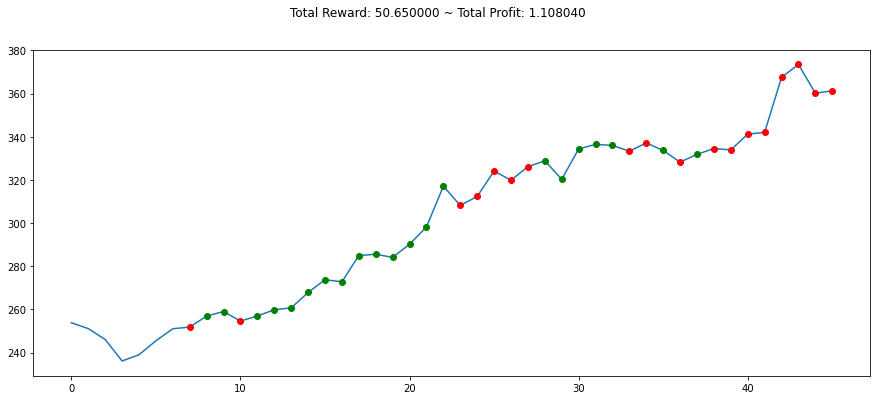

In [41]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

# Saving the model

In [8]:
model.save("dqn_stock")

NameError: name 'model' is not defined

# Loading the model and testing it


In [10]:
model = RecurrentPPO.load('dqn_stock',env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Info: {'total_reward': 22.30000000000001, 'total_profit': 0.9780114663952567, 'position': 0}
Profit: -2.1988533604743288%


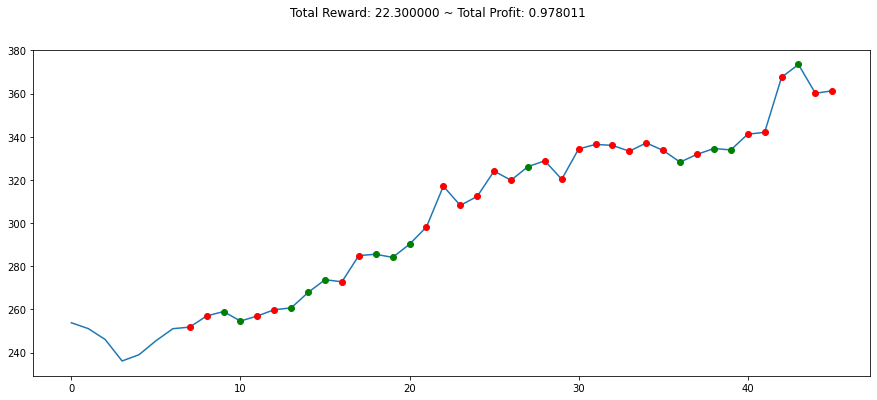

In [15]:
state = env.reset()

while True:
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done:
        print('Info:',info)
        print('Profit:',str((info['total_profit']-1)*100)+'%')
        break
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()